In [1]:
import numpy as np
from pyuvdata import UVData
from hera_qm import xrfi
import matplotlib.pyplot as plt
%matplotlib inline
import glob as glob
import re
import numpy.ma as ma
SPEED_OF_LIGHT = 299792458.
import numpy.fft as fft
import scipy.signal as signal
import aipy.deconv as deconv

could not import sklearn


In [2]:
files = glob.glob('2458432/*.uvh5')
jds = []
for fname in files:
    jd = float(re.findall('[0-9]{7}.[0-9]{5}',fname)[0])
    jds.append(jd)
files = list(np.array(files)[np.argsort(np.array(jds))])

In [3]:
uvd = UVData()
uvd.read_uvh5(files[20:50])
flags = xrfi.xrfi_h1c_pipe(uvd)
uvd.flag_array = flags[0].flag_array

In [4]:
print(np.any(uvd.flag_array))

True


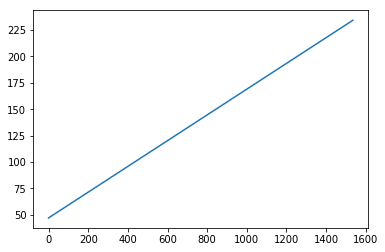

In [5]:
plt.plot(uvd.freq_array.squeeze()/1e6)

In [6]:
def waterfall(uvd,ant1,ant2,pol=0,polstr='XX',logscale=False,quantity='abs'):
    plt.close()
    plt.figure()
    selection = np.logical_and(uvd.ant_1_array == ant1,uvd.ant_2_array == ant2)
    dvals = ma.masked_array(uvd.data_array[selection,:,:,pol].squeeze(),mask=uvd.flag_array[selection,:,:,pol].squeeze())
    
    if quantity == 'abs':
        dvals = np.abs(dvals)
    if quantity == 'real':
        dvals = np.real(dvals)    
    if quantity == 'imag':
        dvals = np.imag(dvals)    
    if quantity == 'phase':
        dvals = np.angle(dvals)    
           
    if logscale:
        dvals = np.log10((dvals))
    print(dvals.shape)
    times = uvd.time_array[selection]
    freqs = uvd.freq_array.squeeze()
    tgrid,fgrid = np.meshgrid(freqs/1e6,times)
    plt.pcolor(tgrid,fgrid,dvals.squeeze())
    plt.gcf().set_size_inches(12,6)
    plt.xlabel('$\\nu$ (MHz)')
    plt.ylabel('JD')
    plt.title('Ant %d x Ant %d %s %s'%(ant1,ant2,polstr,quantity))
    plt.colorbar()

In [7]:
def lineplot(uvd,ant1,ant2,pol=0,polstr='XX',logscale=False,quantity='abs',xaxis='freq'):
    plt.close()
    plt.figure()
    selection = np.logical_and(uvd.ant_1_array == ant1,uvd.ant_2_array == ant2)
    dvals = ma.masked_array(uvd.data_array[selection,:,:,pol].squeeze(),mask=uvd.flag_array[selection,:,:,pol].squeeze())
    
    if quantity == 'abs':
        dvals = np.abs(dvals)
    if quantity == 'real':
        dvals = np.real(dvals)    
    if quantity == 'imag':
        dvals = np.imag(dvals)    
    if quantity == 'phase':
        dvals = np.angle(dvals)    
           
    if logscale:
        dvals = np.log10((dvals))
    print(dvals.shape)
    times = uvd.time_array[selection]
    freqs = uvd.freq_array.squeeze()
    if xaxis == 'freq':
        for tnum,t in enumerate(times):
            plt.plot(freqs,dvals[tnum,:])
        plt.xlabel('$\\nu$ (MHz)')

    elif xaxis == 'time':
        for fnum,f in enumerate(freqs):
            plt.plot(times,dvals[:,fnum])
        plt.xlabel('JD')

    plt.gcf().set_size_inches(12,6)
    #plt.ylabel('JD')
    plt.ylabel('Ant %d x Ant %d %s %s'%(ant1,ant2,polstr,quantity))

(238, 1536)


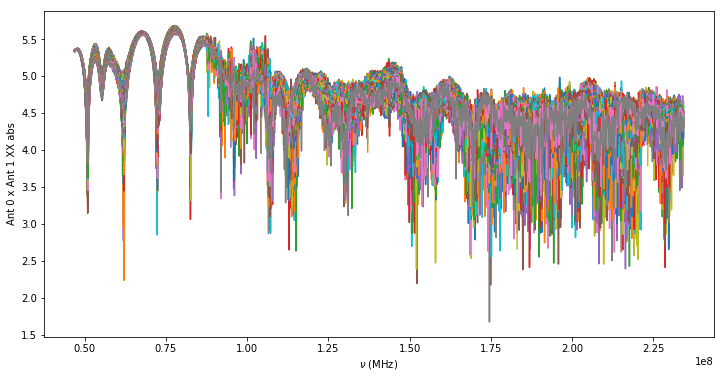

In [8]:
lineplot(uvd,0,1,0,logscale=True)

(238, 1536)


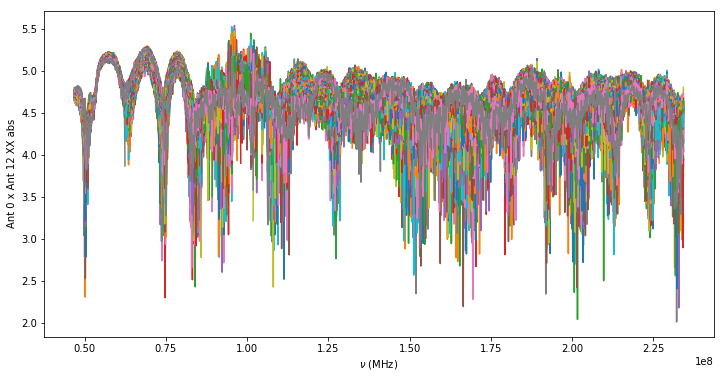

In [9]:
lineplot(uvd,0,12,0,logscale=True)

(238, 1536)


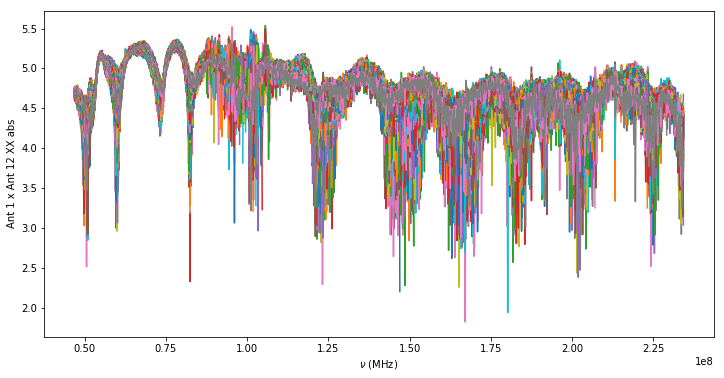

In [10]:
lineplot(uvd,1,12,0,logscale=True)

(238, 1536)


(2458432.415, 2458432.4175)

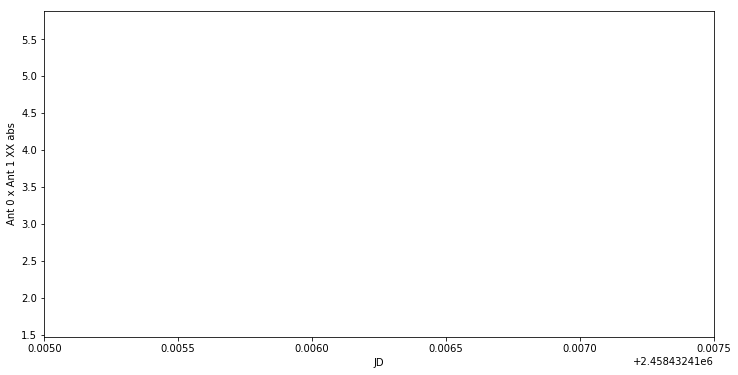

In [11]:
lineplot(uvd,0,1,0,logscale=True,xaxis='time')
plt.xlim(np.array([0.015,0.0175])+2.4584324e6)

## OK. Time for a linear delay-filter.

In [12]:
np.where([True,False,True])[0]

array([0, 2])

In [13]:
WMAT_CACHE = {}

In [14]:
def linear_filter(freqs,ydata,flags,bl_length,h_buffer=0.,filter_factor = 1e-3,weights='I',renormalize=True,output_domain='delay',taper='boxcar'):
    '''
    a linear delay filter that suppresses modes within the wedge by a factor of filter_factor. 
    freqs, nchan vector of frequencies
    ydata, nchan vector of complex data
    flags, nchan bool vector of flags
    '''
    nf = len(freqs)
    #print(nf)
    taper=signal.windows.get_window(taper,nf)
    taper/=taper.sum()
    #taper = np.diag(taper)
    taper_mat = np.diag(taper)
    #print(nf)

    #print(len(np.where(flags)[0]))
    if weights=='I':
        wmat = np.identity(nf)
        wmat[:,flags]=0.
        wmat[flags,:]=0.
    elif weights == 'WTL':
        wkey = (nf,freqs[1]-freqs[0],bl_length,filter_factor,h_buffer)+tuple(np.where(flags)[0])
        if not wkey in WMAT_CACHE:
            fx,fy=np.meshgrid(freqs,freqs)
            tau_bl = bl_length/SPEED_OF_LIGHT + h_buffer
            ff = 2.*(fx-fy)*tau_bl
            cmat_fg = np.sinc(ff)
            cmat = cmat_fg+np.identity(len(freqs))*filter_factor
            #print(flags.shape)
            cmat[:,flags]=0.
            cmat[flags,:]=0.
            #print(np.linalg.cond(cmat))
            wmat = np.linalg.pinv(cmat)*filter_factor
            WMAT_CACHE[wkey]=wmat
        else:
            wmat = WMAT_CACHE[wkey]
    output = np.dot(wmat,ydata)
    output = fft.fftshift(fft.fft(fft.fftshift(output*taper)))
    if renormalize:
        igrid,jgrid = np.meshgrid(np.arange(-nf/2,nf/2),np.arange(-nf/2,nf/2))
        fftmat = np.exp(-2j*np.pi*igrid*jgrid/nf)
        #fftmat[flags,:]=0.
        #fftmat[:,flags]=0.
        mmat = np.dot(fftmat,np.dot(wmat,np.conj(fftmat).T))
        #print(np.linalg.cond(mmat))
        mmat_inv = np.linalg.pinv(mmat)
    else:
        mmat_inv = np.identity(nf)
    output=np.dot(mmat_inv,output)
    delays = np.arange(-nf/2,nf/2)*(freqs[1]-freqs[0])
    if output_domain=='frequency':
        output = fft.ifftshift(fft.ifft(fft.ifftshift(output)))/taper
    #print(output.shape)
    return output,mmat_inv

In [15]:
def waterfall_filter(uvd,ant1,ant2,pol=0,fmin=108e6,fmax=250e6,polstr='XX',logscale=False,quantity='abs',h_buffer = 0.,fg_eps=1e-3,
                          renormalize=False,filter_only=False,weights='I',domain='delay',taper='boxcar',
                          flag_across_time=True,use_max_bl=True,filtermethod='linear',cmin=1e1,cmax=1e5):
    plt.close()
    plt.figure()
    #print(uvd.freq_array)
    #print(fmin)
    #print(uvd.freq_array.squeeze())
    #print(np.logical_and(uvd.freq_array.squeeze()>=fmin,uvd.freq_array.squeeze()<=fmax))
    select_channels = np.where(np.logical_and(uvd.freq_array.squeeze()>=fmin,uvd.freq_array.squeeze()<=fmax))[0]
    if np.mod(len(uvd.freq_array.squeeze()[select_channels]),2)==1:
        select_channels=select_channels[:-1]
    #print(select_channels)
    #print(len(select_channels[select_channels]))
    #print(len(select_channels))
    uvd=uvd.select(freq_chans=select_channels,inplace=False)
    selection = np.logical_and(uvd.ant_1_array == ant1,uvd.ant_2_array == ant2)
    dvals=[]
    mvals=[]
    times = uvd.time_array[selection]
    #for every time
    if use_max_bl:
        b = np.linalg.norm(uvd.uvw_array[selection,:],axis=1).max()
    if flag_across_time:
        f=np.any(uvd.flag_array[selection,:,:,pol],axis=0).squeeze()
    for tnum,tval in enumerate(times):
        #filter 
        d=uvd.data_array[selection,:,:,pol][tnum,0,:]
        if not(flag_across_time):
            f=uvd.flag_array[selection,:,:,pol][tnum,0,:].squeeze()
        if not use_max_bl:
            b = np.linalg.norm(uvd.uvw_array[selection,:][tnum])
        #print(d.shape)
        #print(f.shape)
        #print(b.shape)
        if filtermethod=='linear':
            lv,mv=linear_filter(uvd.freq_array.squeeze(),
                                       d,
                                       f,
                                       b,
                                       h_buffer = h_buffer,output_domain=domain,
                                       filter_factor = fg_eps,weights=weights,renormalize=renormalize,taper=taper)
        elif filtermethod=='clean':
            dkernel = np.ones(len(d),dtype=complex)
            dkernel[f]=0.
            #print(dkernel)
            lv = deconv.clean(im=d,ker=dkernel,tol=1e-3,stop_if_div=False,verbose=False)[1]['res']
            lv,mv=linear_filter(uvd.freq_array.squeeze(),
                                lv,
                                f, 
                                b,weights='I',taper=taper,renormalize=False)
        mvals.append(mv)
        dvals.append(lv)

    dvals = np.array(dvals) 

                    
    if quantity == 'abs':
        dvals = np.abs(dvals)
    if quantity == 'real':
        dvals = np.real(dvals)    
    if quantity == 'imag':
        dvals = np.imag(dvals)    
    if quantity == 'phase':
        dvals = np.angle(dvals)    
    if logscale:
        dvals = np.log10((dvals))
        cmin=np.log10(cmin)
        cmax=np.log10(cmax)
    #print(dvals.shape)
    #print(dvals)
    freqs = uvd.freq_array.squeeze()
    delays = fft.fftshift(fft.fftfreq(len(freqs),freqs[1]-freqs[0]))*1e9
    if domain == 'delay':
        tgrid,fgrid = np.meshgrid(delays,times)
    else:
        tgrid,fgrid = np.meshgrid(freqs/1e6,times)
    plt.pcolor(tgrid,fgrid,dvals.squeeze(),vmin=cmin,vmax=cmax)
    plt.gcf().set_size_inches(12,6)
    if domain =='frequency':
        plt.xlabel('$\\nu$ (MHz)')
    elif domain == 'delay':
        plt.xlabel('$\\tau$ (ns)')
        plt.axvline(-b/SPEED_OF_LIGHT*1e9,color='grey',lw=4,ls='-')
        plt.axvline(b/SPEED_OF_LIGHT*1e9,color='grey',lw=4,ls='-')
        plt.axvline(-b/SPEED_OF_LIGHT*1e9,color='k',lw=2,ls='--')
        plt.axvline(b/SPEED_OF_LIGHT*1e9,color='k',lw=2,ls='--')
    plt.ylabel('JD')
    plt.title('Ant %d x Ant %d %s %s'%(ant1,ant2,polstr,quantity))
    plt.colorbar()
    return(mvals)

In [16]:
def lineplot_filter(uvd,ant1,ant2,pol,fmin=108e6,fmax=250e6,polstr='XX',logscale=False,quantity='abs',h_buffer = 0.,fg_eps=1e-3,
                          renormalize=False,filter_only=False,weights='I',domain='delay',taper='boxcar',
                          flag_across_time=True,use_max_bl=True,filtermethod='linear',ls='-',dish_diam=14.6):
    #plt.close()
    #plt.figure()
    select_channels = np.where(np.logical_and(uvd.freq_array.squeeze()>=fmin,uvd.freq_array.squeeze()<=fmax))[0]
    if np.mod(len(uvd.freq_array.squeeze()[select_channels]),2)==1:
        select_channels=select_channels[:-1]
    #print(len(select_channels[select_channels]))
    #print(select_chans)
    uvd=uvd.select(freq_chans=select_channels,inplace=False)
    nf=len(uvd.freq_array.squeeze())
    selection = np.logical_and(uvd.ant_1_array == ant1,uvd.ant_2_array == ant2)
    dvals=[]
    dval_mean=np.zeros(nf,dtype=complex)
    mvals=[]
    times = uvd.time_array[selection]
    if use_max_bl:
        b = np.linalg.norm(uvd.uvw_array[selection,:],axis=1).max()+dish_diam
    #for every time
    if flag_across_time:
        f=np.any(uvd.flag_array[selection,:,:,pol],axis=0).squeeze()
    for tnum,tval in enumerate(times):
        #filter 
        d=uvd.data_array[selection,:,:,pol][tnum,0,:]
        if not flag_across_time:
            f=uvd.flag_array[selection,:,:,pol][tnum,0,:].squeeze()
        if not use_max_bl:
            b = np.linalg.norm(uvd.uvw_array[selection,:][tnum])+dish_diam
        #print(d.shape)
        #print(f.shape)
        #print(b.shape)
        if filtermethod=='linear':
            lv,mv=linear_filter(uvd.freq_array.squeeze(),
                                       d,
                                       f,
                                       b,
                                       h_buffer = h_buffer,output_domain=domain,
                                       filter_factor = fg_eps,weights=weights,renormalize=renormalize,taper=taper)
        elif filtermethod=='clean':
            dkernel = np.ones(len(d),dtype=complex)
            dkernel[f]=0.
            lv = deconv.clean(im=d,ker=dkernel,tol=1e-3,stop_if_div=False,verbose=False)[1]['res']
            lv,mv=linear_filter(uvd.freq_array.squeeze(),
                                lv,
                                f, 
                                b,weights='I',taper=taper,renormalize=False)
  
        dvals.append(lv)
        dval_mean+=lv
        mvals.append(mv)
    dvals = np.array(dvals) 
    dval_mean/=len(dvals)
    #compute noise level in each channel across time
    noise_level = np.sqrt(.5*(np.std(dvals.real)**2.+np.std(dvals.imag)**2.))
    if quantity == 'abs':
        dvals = np.abs(dvals)
        dval_mean=np.abs(dval_mean)
    if quantity == 'real':
        dvals = np.real(dvals)    
        dval_mean=np.real(dval_mean)
    if quantity == 'imag':
        dvals = np.imag(dvals)    
        dval_mean=np.imag(dval_mean)
    if quantity == 'phase':
        dvals = np.angle(dvals)  
        dval_mean=np.angle(dval_mean)
    #if logscale:
    #    dvals = np.log10((dvals))
    #print(dvals.shape)
    freqs = uvd.freq_array.squeeze()
    delays = fft.fftshift(fft.fftfreq(len(freqs),freqs[1]-freqs[0]))*1e9
    if domain == 'frequency':
        for tnum,t in enumerate(times):
            plt.plot(freqs/1e6,dvals[tnum,:],ls=ls)
        plt.xlabel('$\\nu$ (MHz)')
        plt.plot(freqs/1e6,np.mean(dvals,axis=0),color='k',lw=3,ls=ls)
    elif domain == 'delay':
        for tnum,t in enumerate(times):
            plt.plot(delays,dvals[tnum,:])
        plt.xlabel('$\\tau$ (ns)')
        plt.axvline(-b/SPEED_OF_LIGHT*1e9,color='grey',lw=4,ls='-')
        plt.axvline(b/SPEED_OF_LIGHT*1e9,color='grey',lw=4,ls='-')
        plt.axvline(-b/SPEED_OF_LIGHT*1e9,color='k',lw=2,ls='--')
        plt.axvline(b/SPEED_OF_LIGHT*1e9,color='k',lw=2,ls='--')
        plt.plot(delays,dval_mean,color='k',lw=3,ls=ls)
    if logscale:
        plt.yscale('log')
    #plt.ylabel('JD')
    plt.ylabel('Ant %d x Ant %d %s %s'%(ant1,ant2,polstr,quantity))
    return mvals

## Comparison between foreground filtered data and blackman-harris delay-transform

Lets start out by comparing the delay transform of a relatively clean band, 150-175 MHz in autos. 

Here is an auto-correlation. There are some flags. And then there are the spiky things. 

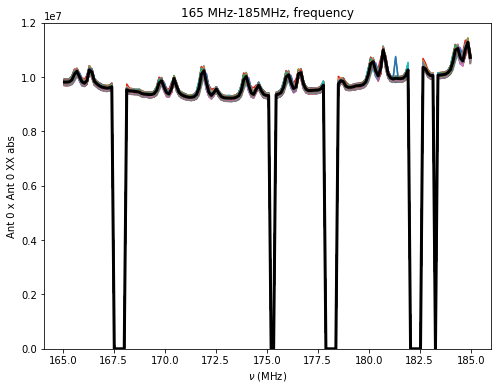

In [17]:
mv_id=lineplot_filter(uvd,0,0,0,fmin=165e6,fmax=185e6,logscale=False,weights='I',
                      flag_across_time=True,renormalize=False,taper='boxcar',domain='frequency')
plt.ylim(0,1.2e7)
plt.title('165 MHz-185MHz, frequency')
plt.gcf().set_size_inches(8,6)
plt.show()


The flags introduce substantial ringing. 

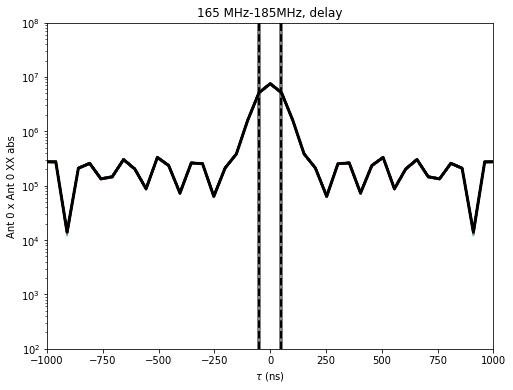

In [18]:
mv_id=lineplot_filter(uvd,0,0,0,fmin=65e6,fmax=85e6,logscale=True,weights='I',flag_across_time=True,renormalize=False,taper='blackmanharris')
plt.ylim(1e2,1e8)
plt.xlim(-1000,1000)
plt.gcf().set_size_inches(8,6)
plt.title('165 MHz-185MHz, delay')
plt.show()

Using WTL weighting helps suppress the wedge and shows non-side-lobe structures that are roughly three orders of magnitude down.

# Applying a dish-scale filter. Low band. 

 Now lets use a wedge-filter. For an auto-correlation, this is just subtracting the average. If do not account for dish width in the subtraction range, then we are just subtracting an average for the auto-correlation with a WTL filter. We can start with no dish width being taken into account. When we do this, the autocorrelation has residual structure. 

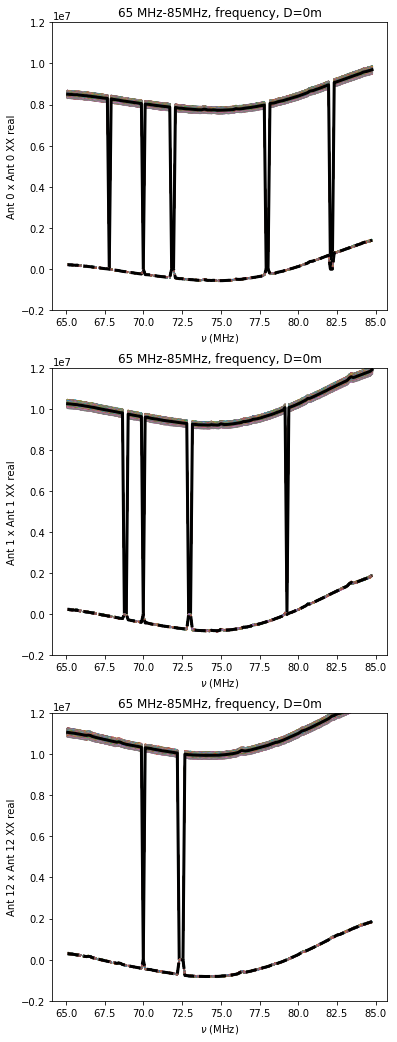

In [19]:
fig=plt.figure()
fax,axarr = plt.subplots(3,1)
ants = [0,1,12]
fmins=[65e6]
fmaxs=[85e6]
for m in range(3):
    for n in range(1):
        plt.sca(axarr[m])
        lineplot_filter(uvd,ants[m],ants[m],0,fmin=fmins[n],fmax=fmaxs[n],logscale=False,weights='I',dish_diam=0.,
                                  flag_across_time=True,renormalize=False,taper='boxcar',domain='frequency',quantity='real')

        lineplot_filter(uvd,ants[m],ants[m],0,fmin=fmins[n],fmax=fmaxs[n],logscale=False,ls='--',dish_diam=0.,
                                  weights='WTL',flag_across_time=True,renormalize=False,taper='boxcar',domain='frequency',quantity='real')
        plt.ylim(-0.2e7,1.2e7)
        plt.gcf().set_size_inches(8,6)
        plt.title('%d MHz-%dMHz, frequency, D=0m'%(fmins[n]/1e6,fmaxs[n]/1e6))
plt.gcf().set_size_inches(6,18)

## Adding dish scale buffer to filtering region leads go much better suppression. 

when we allow dish diameter to be 14.6 meters, the residual auto-correlation has now structure!

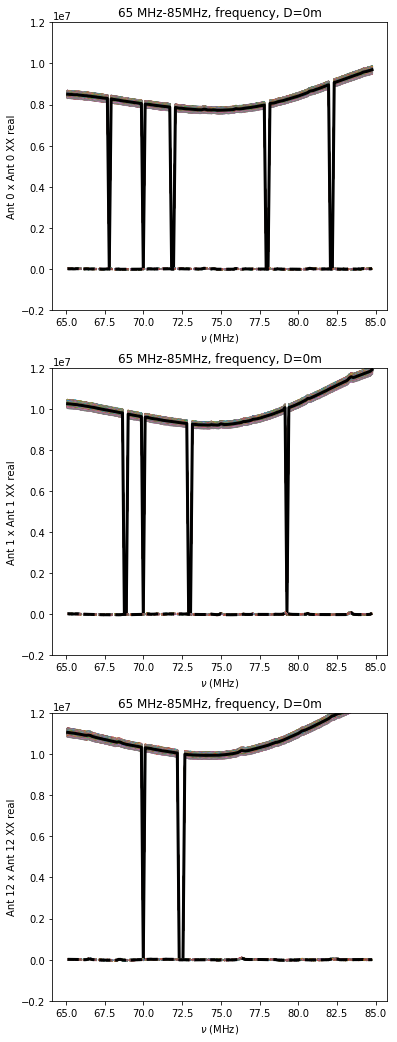

In [21]:
fig=plt.figure()
fax,axarr = plt.subplots(3,1)
ants = [0,1,12]
fmins=[65e6]
fmaxs=[85e6]
for m in range(3):
    for n in range(1):
        plt.sca(axarr[m])
        lineplot_filter(uvd,ants[m],ants[m],0,fmin=fmins[n],fmax=fmaxs[n],logscale=False,weights='I',dish_diam=14.6,
                                  flag_across_time=True,renormalize=False,taper='boxcar',domain='frequency',quantity='real')

        lineplot_filter(uvd,ants[m],ants[m],0,fmin=fmins[n],fmax=fmaxs[n],logscale=False,ls='--',dish_diam=14.6,
                                  weights='WTL',flag_across_time=True,renormalize=False,taper='boxcar',domain='frequency',quantity='real')
        plt.ylim(-0.2e7,1.2e7)
        plt.title('%d MHz-%dMHz, frequency, D=0m'%(fmins[n]/1e6,fmaxs[n]/1e6))
plt.gcf().set_size_inches(6,18)

## What about the divet?

If we extend the bottom of our band down to 45 MHz, we encounter the wierd divit. This has super-dish delay structure which is probably caused by the cabling?

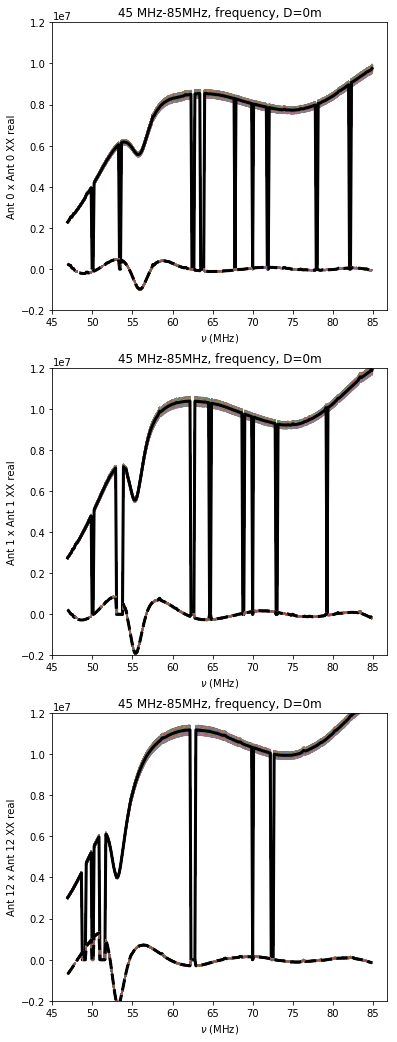

In [22]:
fig=plt.figure()
fax,axarr = plt.subplots(3,1)
ants = [0,1,12]
fmins=[45e6]
fmaxs=[85e6]
for m in range(3):
    for n in range(1):
        plt.sca(axarr[m])
        lineplot_filter(uvd,ants[m],ants[m],0,fmin=fmins[n],fmax=fmaxs[n],logscale=False,weights='I',dish_diam=14.6,
                                  flag_across_time=True,renormalize=False,taper='boxcar',domain='frequency',quantity='real')

        lineplot_filter(uvd,ants[m],ants[m],0,fmin=fmins[n],fmax=fmaxs[n],logscale=False,ls='--',dish_diam=14.6,
                                  weights='WTL',flag_across_time=True,renormalize=False,taper='boxcar',domain='frequency',quantity='real')
        plt.ylim(-0.2e7,1.2e7)
        plt.gcf().set_size_inches(8,6)
        plt.title('%d MHz-%dMHz, frequency, D=0m'%(fmins[n]/1e6,fmaxs[n]/1e6))
plt.gcf().set_size_inches(6,18)

In [49]:
print(1/7.5e6*1e9)
print(133.3/3)

133.333333333
44.4333333333


## Zooming in on small scale structure outside of the divet. 

Now lets inspect the real component of the delay-transform with the dish wedge filtered. Averaging the auto-correlations in time, we discover the 2.5 MHz ripples that are very apparent at high frequency. There may also be a high order reflection. Perhaps its the same one that causes the divet. The period is roughly 7.5 MHz which corresponds to a round trip time of **133 ns** or **44.4 meters** or a **22 meter one-way**. **This may be the third order reflection between the dish and feed.** We also see the 2.5 MHz spikey features that are in the high band data. 

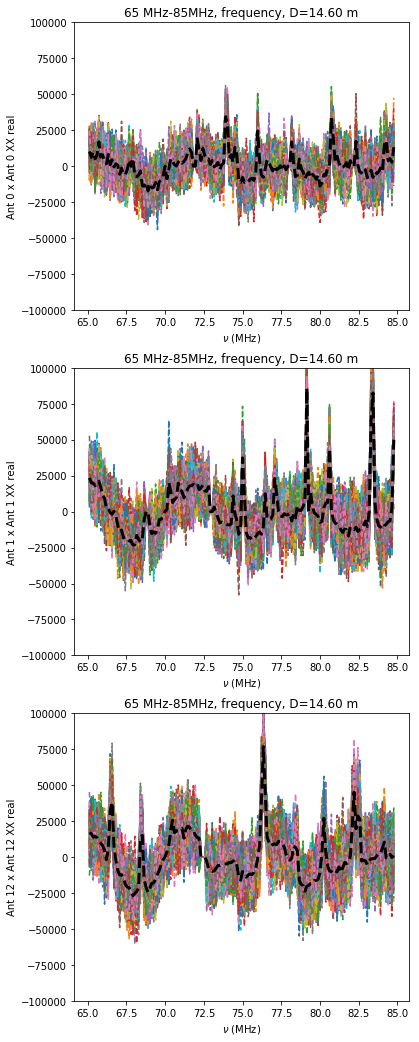

In [46]:
fig=plt.figure()
fax,axarr = plt.subplots(3,1)
ants = [0,1,12]
fmins=[65e6]
fmaxs=[85e6]
for m in range(3):
    for n in range(1):
        plt.sca(axarr[m])
        mv_id=lineplot_filter(uvd,ants[m],ants[m],0,fmin=fmins[n],fmax=fmaxs[n],logscale=False,ls='--',dish_diam=14.6,
                      weights='WTL',flag_across_time=True,renormalize=False,taper='boxcar',domain='frequency',quantity='real')
        plt.ylim(-1e5,1e5)
        plt.title('%d MHz-%dMHz, frequency, D=%.2f m'%(fmins[n]/1e6,fmaxs[n]/1e6,dd))
plt.gcf().set_size_inches(6,18)


## The delay domain

Glancing in the delay domain outside of the divet, there appear to be ***peaks at 125 ns**. It is hard to tell since its close to the foreground decimation region (dashed vertical lines). 

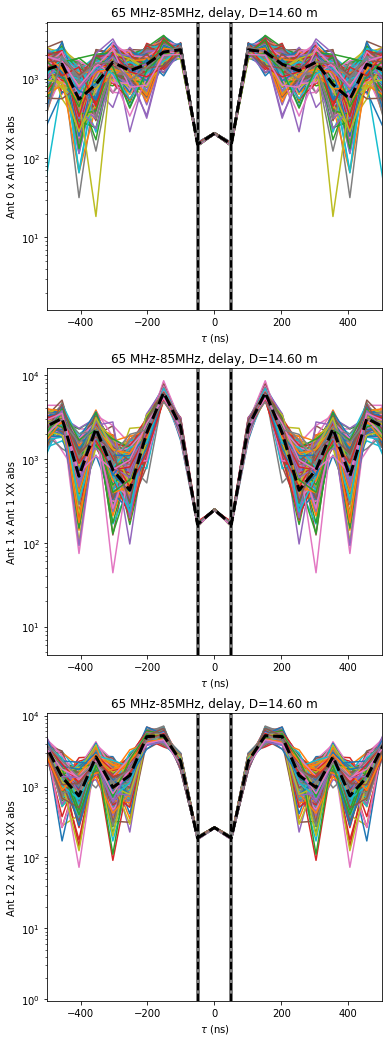

In [44]:
fig=plt.figure()
fax,axarr = plt.subplots(3,1)
ants = [0,1,12]
fmins=[65e6]
fmaxs=[85e6]
dd=14.6
for m in range(3):
    for n in range(1):
        plt.sca(axarr[m])
        mv_id=lineplot_filter(uvd,ants[m],ants[m],0,fmin=fmins[n],fmax=fmaxs[n],logscale=True,ls='--',dish_diam=dd,
                      weights='WTL',flag_across_time=True,renormalize=False,fg_eps=1e-3,taper='boxcar',domain='delay',quantity='abs')
        #plt.ylim(-1e5,1e5)
        plt.title('%d MHz-%dMHz, delay, D=%.2f m'%(fmins[n]/1e6,fmaxs[n]/1e6,dd))
        plt.xlim(-500,500)
plt.gcf().set_size_inches(6,18)


## Including the divet. 

When we add the divet back in, what happens to the delay domain? Now we clearly see a ripple structure with a period of **8-14 MHz**.

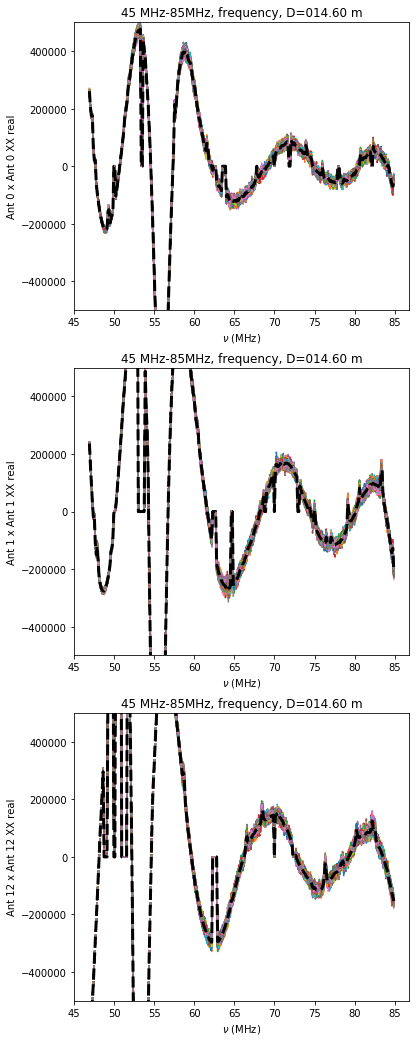

In [45]:
fig=plt.figure()
fax,axarr = plt.subplots(3,1)
ants = [0,1,12]
fmins=[45e6]
fmaxs=[85e6]
dd=14.6
for m in range(3):
    for n in range(1):
        plt.sca(axarr[m])
        mv_id=lineplot_filter(uvd,ants[m],ants[m],0,fmin=fmins[n],fmax=fmaxs[n],logscale=False,ls='--',dish_diam=dd,
                      weights='WTL',flag_across_time=True,renormalize=False,taper='boxcar',domain='frequency',quantity='real')
        plt.ylim(-5e5,5e5)
        plt.title('%d MHz-%dMHz, frequency, D=0%.2f m'%(fmins[n]/1e6,fmaxs[n]/1e6,dd))
plt.gcf().set_size_inches(6,18)


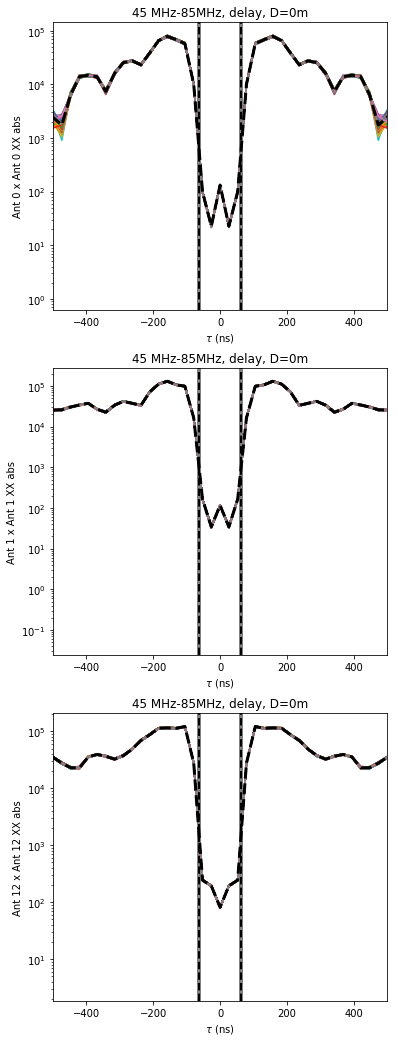

In [39]:
fig=plt.figure()
fax,axarr = plt.subplots(3,1)
ants = [0,1,12]
fmins=[45e6]
fmaxs=[85e6]
for m in range(3):
    for n in range(1):
        plt.sca(axarr[m])
        mv_id=lineplot_filter(uvd,ants[m],ants[m],0,fmin=fmins[n],fmax=fmaxs[n],logscale=True,ls='--',dish_diam=18.6,
                      weights='WTL',flag_across_time=True,renormalize=False,fg_eps=1e-3,taper='boxcar',domain='delay',quantity='abs')
        #plt.ylim(-1e5,1e5)
        plt.title('%d MHz-%dMHz, delay, D=0m'%(fmins[n]/1e6,fmaxs[n]/1e6))
        plt.xlim(-500,500)
plt.gcf().set_size_inches(6,18)


## Delay Domain 45-85 MHz. 

Here is the same plot in delay-space. 

I next do the same thing for 45 to 85 MHz. 

Subtracting the average helps... We remove power from the dish 

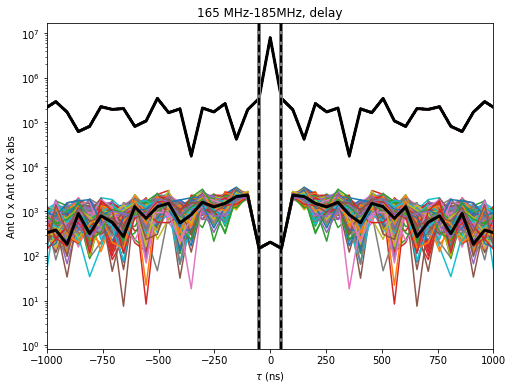

In [452]:
mv_id=lineplot_filter(uvd,0,0,0,fmin=65e6,fmax=85e6,logscale=True,weights='I',flag_across_time=True,renormalize=False,taper='boxcar',quantity='abs',fg_eps=1e-5)
mv_id=lineplot_filter(uvd,0,0,0,fmin=65e6,fmax=85e6,logscale=True,weights='WTL',flag_across_time=True,renormalize=False,taper='boxcar',quantity='abs',fg_eps=1e-3)
#plt.ylim(-1e3,1e3)
plt.xlim(-1000,1000)
plt.gcf().set_size_inches(8,6)
plt.title('165 MHz-185MHz, delay')
plt.show()

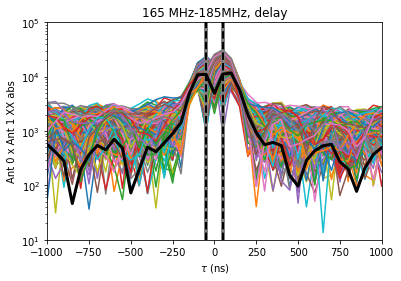

In [379]:
mv_id=lineplot_filter(uvd,0,1,0,fmin=165e6,fmax=185e6,quantity='abs',logscale=True,weights='I',flag_across_time=True,renormalize=False,taper='blackmanharris')
plt.ylim(1e1,1e5)
plt.xlim(-1000,1000)
plt.title('165 MHz-185MHz, delay')
plt.show()

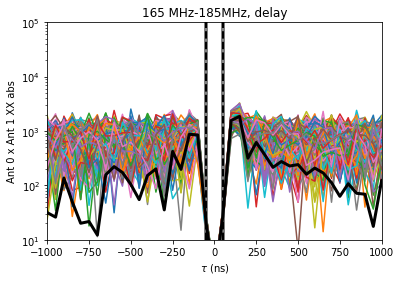

In [374]:
mv_id=lineplot_filter(uvd,0,1,0,fmin=165e6,fmax=185e6,logscale=True,weights='WTL',flag_across_time=True,renormalize=False,taper='boxcar')
plt.ylim(1e1,1e5)
plt.xlim(-1000,1000)
plt.title('165 MHz-185MHz, delay')
plt.show()

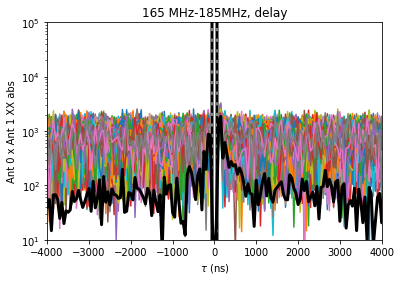

In [377]:
mv_id=lineplot_filter(uvd,0,1,0,fmin=165e6,fmax=185e6,logscale=True,weights='WTL',flag_across_time=True,renormalize=False,taper='boxcar',quantity='abs')
plt.ylim(1e1,1e5)
plt.xlim(-4000,4000)
plt.title('165 MHz-185MHz, delay')
plt.show()

invalid value encountered in log10


(-1000, 1000)

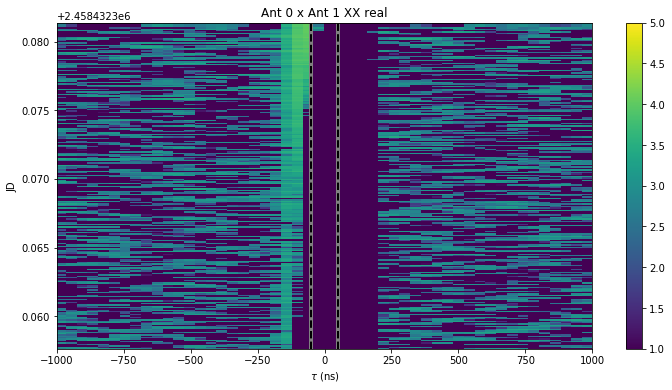

In [299]:
mvals_i=waterfall_filter(uvd,0,1,0,fmin=150e6,fmax=175e6,logscale=True,taper='blackmanharris',quantity='real')
plt.xlim(-1000,1000)

invalid value encountered in log10


(-1000, 1000)

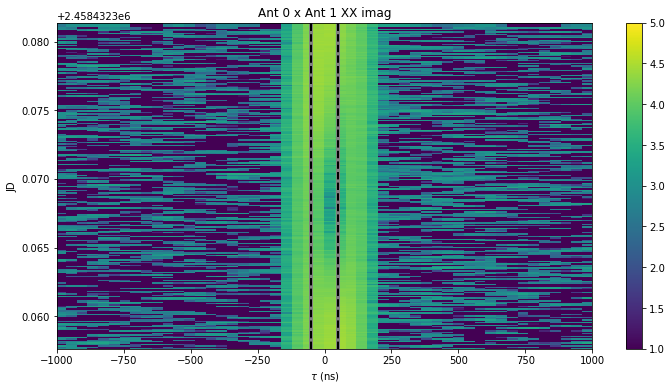

In [301]:
mvals_i=waterfall_filter(uvd,0,1,0,fmin=150e6,fmax=175e6,logscale=True,taper='blackmanharris',quantity='abs')
plt.xlim(-1000,1000)

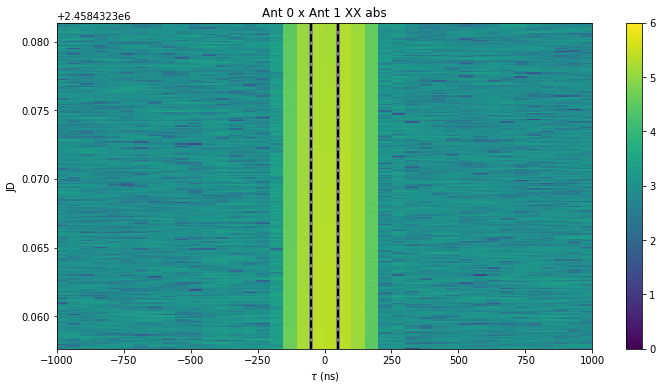

In [322]:
mv_wtl=waterfall_filter(uvd,0,1,0,fmin=65e6,fmax=85e6,logscale=True,
                        renormalize=False,taper='blackmanharris',quantity='abs',cmin=1e0,cmax=1e6)
#plt.ylim(1e1,1e5)
plt.xlim(-1000,1000)
plt.show()
#plt.xlim(-200,200)
#plt.pcolor(mv_wtl[0])

invalid value encountered in log10


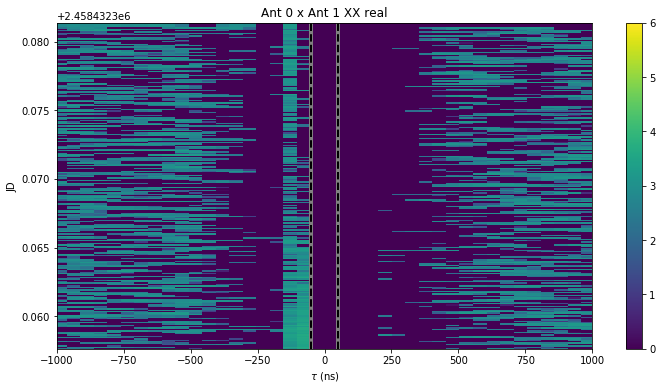

In [325]:
mv_wtl=waterfall_filter(uvd,0,1,3,fmin=65e6,fmax=85e6,logscale=True,
                        renormalize=False,taper='blackmanharris',quantity='real',cmin=1e0,cmax=1e6)
#plt.ylim(1e1,1e5)
plt.xlim(-1000,1000)
plt.show()
#plt.xlim(-200,200)
#plt.pcolor(mv_wtl[0])

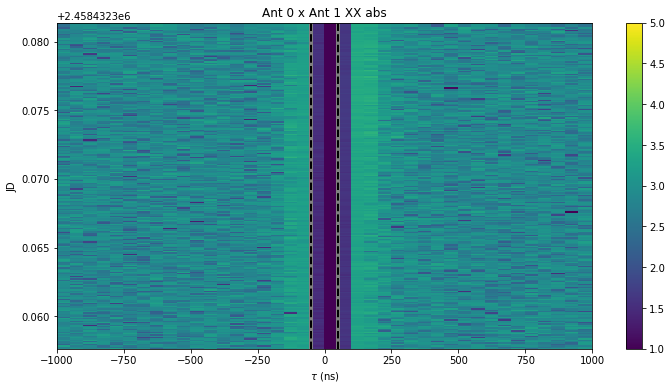

In [307]:
mv_wtl=waterfall_filter(uvd,0,1,0,fmin=155e6,fmax=175e6,logscale=True,weights='WTL',flag_across_time=True,fg_eps=1e-3,renormalize=False,taper='boxcar',quantity='abs')
#plt.ylim(1e1,1e5)
plt.xlim(-1000,1000)
plt.show()
#plt.xlim(-200,200)
#plt.pcolor(mv_wtl[0])

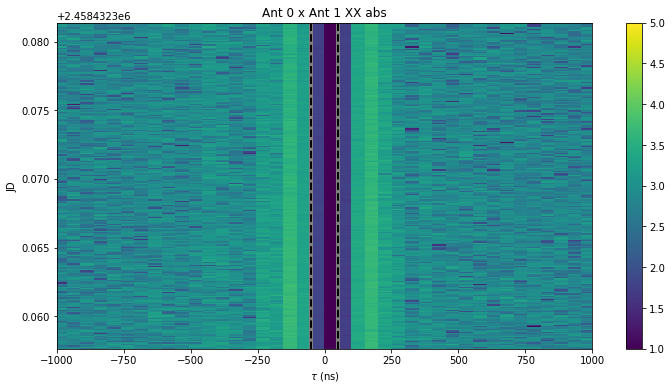

In [332]:
mv_wtl=waterfall_filter(uvd,0,1,0,fmin=65e6,fmax=85e6,logscale=True,weights='WTL',flag_across_time=True,fg_eps=1e-3,renormalize=False,taper='boxcar',quantity='abs')
#plt.ylim(1e1,1e5)
plt.xlim(-1000,1000)
plt.show()
#plt.xlim(-200,200)
#plt.pcolor(mv_wtl[0])

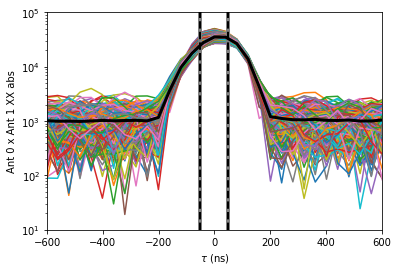

In [268]:
mv_id=lineplot_filter(uvd,0,1,0,fmin=150e6,fmax=175e6,logscale=True,weights='I',flag_across_time=True,renormalize=False,taper='blackmanharris')
#plt.ylim(1e-2,1e3)
plt.ylim(1e1,1e5)
plt.xlim(-600,600)

#plt.xlim(-200,200)
plt.show()
#plt.pcolor(mv_id[0])

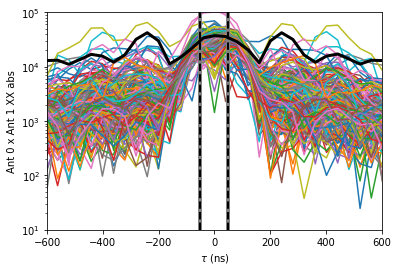

In [269]:
mv_id=lineplot_filter(uvd,0,1,0,fmin=150e6,fmax=175e6,logscale=True,weights='I',flag_across_time=True,
                      renormalize=False,taper='blackmanharris',filtermethod='clean')
#plt.ylim(1e-2,1e3)
plt.ylim(1e1,1e5)
plt.xlim(-600,600)

#plt.xlim(-200,200)
plt.show()
#plt.pcolor(mv_id[0])

In [ ]:
mv_id=lineplot_filter(uvd,0,1,0,fmin=150e6,fmax=175e6,logscale=True,weights='I',flag_across_time=True,renormalize=False,taper='blackmanharris')
#plt.ylim(1e-2,1e3)
plt.ylim(1e1,1e5)
plt.xlim(-600,600)

#plt.xlim(-200,200)
plt.show()
#plt.pcolor(mv_id[0])

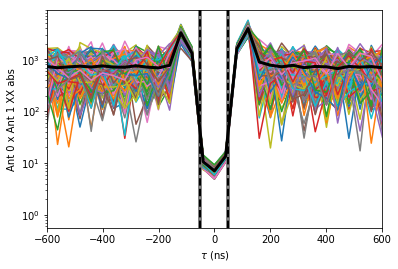

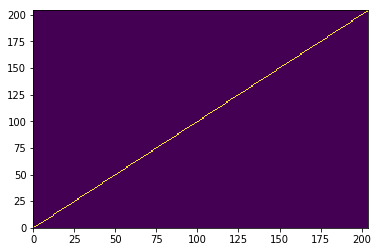

In [334]:
mv_id=lineplot_filter(uvd,0,1,0,fmin=150e6,fmax=175e6,logscale=True,weights='WTL',flag_across_time=True,renormalize=False,taper='boxcar')
#plt.ylim(1e-2,1e3)
#plt.ylim(1e1,1e5)
plt.xlim(-600,600)

#plt.xlim(-200,200)
plt.show()
plt.pcolor(mv_id[0])

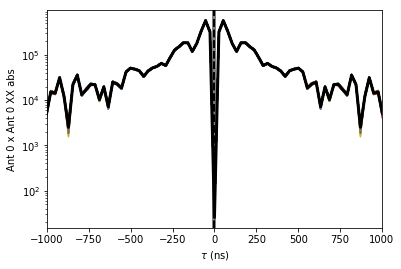

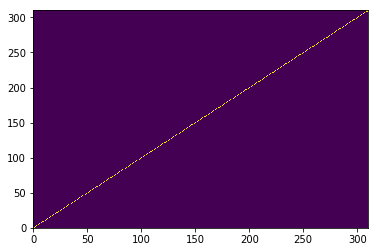

In [271]:
mv_wtl=lineplot_filter(uvd,0,0,0,fmin=50e6,fmax=88e6,logscale=True,weights='WTL',flag_across_time=True,fg_eps=1e-3,renormalize=False,taper='boxcar',quantity='abs')
#plt.ylim(1e1,1e5)
plt.xlim(-1000,1000)
plt.show()
#plt.xlim(-200,200)
plt.pcolor(mv_wtl[0])

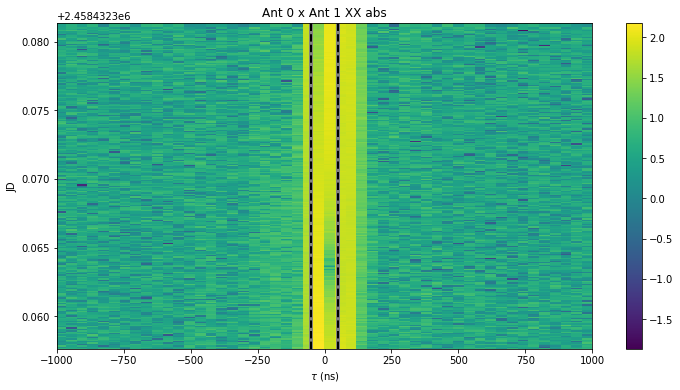

In [288]:
mv_wtl=waterfall_filter(uvd,0,1,0,fmin=150e6,fmax=175e6,logscale=True,weights='WTL',flag_across_time=True,fg_eps=1e-3,renormalize=True,taper='boxcar',quantity='abs')
#plt.ylim(1e1,1e5)
plt.xlim(-1000,1000)
plt.show()
#plt.xlim(-200,200)
#plt.pcolor(mv_wtl[0])

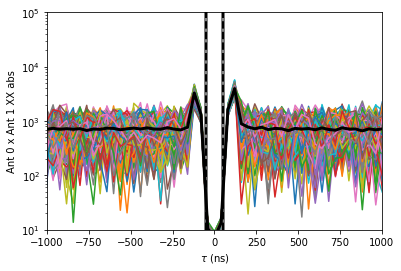

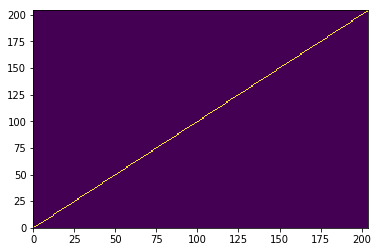

In [273]:
mv_wtl=lineplot_filter(uvd,0,1,0,fmin=150e6,fmax=175e6,logscale=True,weights='WTL',flag_across_time=True,fg_eps=1e-3,renormalize=False,taper='boxcar',quantity='abs')
plt.ylim(1e1,1e5)
plt.xlim(-1000,1000)
plt.show()
#plt.xlim(-200,200)
#plt.pcolor(mv_wtl[0])

[[2.90185988 2.78425483 2.30852764 ... 3.2667378  2.93403969 2.86410105]
 [2.5744676  2.76543696 2.74633457 ... 2.86723643 1.96384368 2.91365591]
 [2.80907774 2.63248009 2.92774487 ... 2.97076019 2.92477127 2.80134741]
 ...
 [2.98748939 2.77287303 2.48763366 ... 2.86913857 2.83815511 2.56554882]
 [2.58047779 2.52886978 2.50603564 ... 2.54393215 2.28788449 2.45566896]
 [3.08927789 3.00663518 3.0610788  ... 2.65871385 3.02357915 2.49546855]]


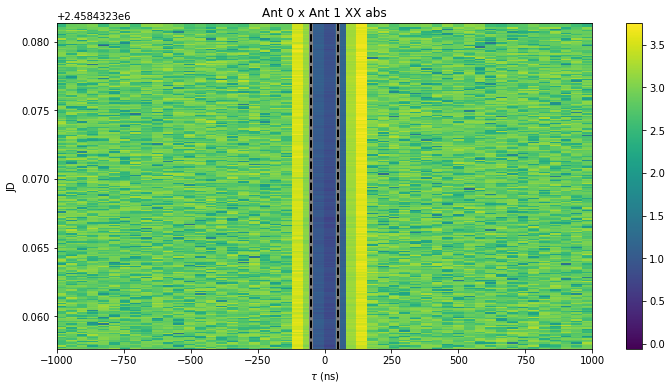

In [281]:
mv_wtl=waterfall_filter(uvd,0,1,0,fmin=150e6,fmax=175e6,logscale=True,weights='WTL',flag_across_time=True,fg_eps=1e-3,renormalize=False,taper='boxcar',quantity='abs')
#plt.ylim(1e1,1e5)
plt.xlim(-1000,1000)
plt.show()
#plt.xlim(-200,200)
#plt.pcolor(mv_wtl[0])

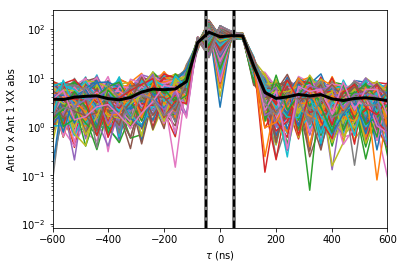

In [280]:
mv_wtl=lineplot_filter(uvd,0,1,0,fmin=150e6,fmax=175e6,logscale=True,weights='WTL',flag_across_time=True,fg_eps=1e-3,renormalize=True,taper='boxcar')
#plt.ylim(1e1,1e5)
plt.xlim(-600,600)
plt.show()
#plt.xlim(-200,200)
#plt.pcolor(np.log10(np.abs(mv_wtl[0])))
#plt.colorbar()
